In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
import copy
from omegaconf import OmegaConf 
from datetime import datetime

import scipy.stats as stats
import numpy as np
import jsonlines
from pathlib import Path
from hydra import initialize, compose
import torchvision

import dr_util.file_utils as fu
import dr_gen.utils.model as mu
import dr_gen.utils.run as ru

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config and Generator

In [2]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
    )

In [3]:
generator = ru.set_deterministic(cfg.seed)

### Utils

#### Log Loading and Parsing

In [6]:
# Return a list of [(file_path, file_contents), ...]
def get_all_logs(base_dir):
    print(f">> Getting logs from all runs in: {base_dir}")
    log_dir = Path(base_dir)
    all_files = [f for f in log_dir.rglob("*.jsonl") if f.is_file()]
    print(f">>    found files: {len(all_files)}")
    return [(str(f), fu.load_file(str(f))) for f in all_files]

In [7]:
# Extract from logs: cfg, metrics[split] = [{k: v}, ...], metadata
def parse_run_log(log_file, log_data):
    # Setup the run metadata
    run_metadata = {
        "error_info": [],
        "parsed_log_file": log_file,
        "parse_time": datetime.now(),
        "train_time": None,
    }
    if len(log_data) < 2:
        run_metadata["error_info"].append(f">> file length: {len(log_data)}")
        return None, None, run_metadata
    
    # Cfg should be logged as the first line
    if "type" not in log_data[0] or log_data[0]['type'] != "dict_config":
        run_metadata["error_info"].append(">> Log file doesn't have cfg as first line")
        return None, None, run_metadata

    # Get the train_time from the logs
    run_cfg = copy.deepcopy(log_data[0].get("value", {}))
    if log_data[-2].get("type", None) == "str" and "value" in log_data[-2]:
        run_metadata["train_time"] = log_data[-2]['value'].strip("Training time ")
        
    # Extract the metrics from rest of logged lines
    metrics = defaultdict(list)
    epoch = defaultdict(int)
    for l in log_data[1:-1]:
        # Skip all the logged strings
        if l.get("type", None) == "str":
            continue


        # If the data has a name and agg_stats, collect it
        split = l.get("data_name", None)
        stats = l.get("agg_stats", None)
        if split is not None and stats is not None:
            metrics[split].append({"epoch": epoch[split], **stats})
            epoch[split] += 1

    # Do some verification
    expected_epochs = run_cfg['epochs']
    for k, v in metrics.items():
        if v[-1]['epoch'] != expected_epochs - 1:
            run_metadata['error_info'].append(
                f">> {k} only has {v[-1]['epoch']+1} / {expected_epochs} epochs"
            )
        
    return run_cfg, dict(metrics), run_metadata

In [8]:
# Parse all run logs
def parse_run_logs(all_files_data):
    runs_cfg_metrics_metadata = []
    for file_path, contents in all_files_data:
        runs_cfg_metrics_metadata.append(
            parse_run_log(file_path, contents)
        )
    return runs_cfg_metrics_metadata

In [ ]:
def get_all_keys(cfg, prefix=""):
    all_keys = []
    for k, v in cfg.items():
        name = f"{prefix}.{k}" if prefix != "" else k
        if isinstance(v, dict):
            all_keys.extend(get_all_keys(v, prefix=name))
        else:
            all_keys.append(name)
    return all_keys

In [57]:
def flat_key_to_val(cfg, flat_key):
    kks = flat_key.split(".")
    val = cfg
    for k in kks:
        val = val[k]
    return val

In [46]:
def cfg_to_flattened_kv(cfg, all_keys=None):
    if all_keys is None:
        all_keys = get_all_keys()
    flat_cfg = {}
    for flat_k in all_keys:
        flat_cfg[flat_k] = flat_key_to_val(cfg, flat_k)
    return flat_cfg

In [73]:
def extract_sweeps(
    runs_cfg_metrics_metadata,
    exclude_keys=[
        "paths.run_dir",
        "write_checkpoint",
    ],
):
    if len(runs_cfg_metrics_metadata) == 0:
        return {}
    all_keys = get_all_keys(runs_cfg_metrics_metadata[0][0])
    
    varying_keys = defaultdict(set)
    kv_to_ind = {k: defaultdict(list) for k in all_keys}
    for i, run in enumerate(runs_cfg_metrics_metadata):
        if len(run) != 3 or run[0] is None:
            continue
        flat_cfg = cfg_to_flattened_kv(run[0], all_keys=all_keys)
        for k in all_keys:
            if k in exclude_keys:
                continue
            kv_to_ind[k][str(v)].append(i)
    for k, v in kv_to_ind.items():
        if len(v) > 1:
            varying_keys[k] = v.keys()
    return kv_to_ind, varying_keys

In [10]:
# Selects runs that finished without error that match criteria (None == any)
#    returns a list of [(cfg, metrics, metadta), ...] for selected
#    and a list of error runs
def filter_parsed_runs(parsed_rs, lr=None, wd=None, init=None):
    subset = []
    error_subset = []
    for cf, ms, md in parsed_rs:
        # Check for errors in run
        # - first runs that aren't finished
        if cf is None or ms is None or len(md['error_info']):
            error_subset.append((cf, ms, md))
            continue
        # - then runs that don't have values for sweep vals
        if cf['optim']['lr'] == '' or cfg['optim']['weight_decay'] == '':
            error_subset.append((cf, ms, md))
            continue

        # Then skip good runs that don't match filter criteria
        if lr is not None and float(cf['optim']['lr']) != lr:
            continue
        if wd is not None and float(cf['optim']['weight_decay']) != wd:
            continue
        if init == "random" and cf['model']['weights'] is not None:
            continue
        elif init == "pretrained" and cf['model']['weights'] != "DEFAULT":
            continue

        # Finally add matching good runs to our run list
        subset.append((cf, ms, md))

    return subset, error_subset

In [11]:
# Filter out error runs and split the parsed runs by sweep metrics
# Returns {"group_name": [(cfg, metrics, metadata), ...]} and a list of error runs
#     metrics = {"split": [{"epoch": ..., metric_name: value, ...}, ....]
def get_run_groups(
    parsed_rs,
    lrs=[0.01, 0.1, 0.2], wds=[1e-4, 1e-5],
    inits=["random", "pretrained"],
):
    good_runs, error_runs = filter_parsed_runs(
        parsed_rs, lr=None, wd=None, init=None, # None == any
    )
    
    run_groups = {}
    for init in inits:
        for lr in lrs:
            for wd in wds:
                rgs, _ = filter_parsed_runs(
                    good_runs, lr=lr, wd=wd, init=init,
                )
                group_name = f'{init}_lr{lr}_wd{wd}' 
                if len(rgs) > 0:
                    print(f" - {group_name:30} | found {len(rgs)}")
                    run_groups[f'{init}_lr{lr}_wd{wd}'] = rgs
                else:
                    print(f" - {group_name:30} | No runs")
    print(f">> Total error or unfinished runs: {len(error_runs)}")
    return run_groups, error_runs

In [12]:
def extract_all_run_group_metrics(
    run_group,
    splits=['train', 'val', 'eval'],
    metric_names=['epoch', 'loss', 'acc1', 'acc5'],
):
    # input: [(cfg, run_met, md) for run in run_group]
    #        run_met = {split: [{"epoch": ..., "metric_name": val, ...} for epochs]}
    # goal: { split: metric_name: [values_list for run in run_group] }
    metrics = {spl: {mn: [] for mn in metric_names} for spl in splits}
    for _, run_metrics, _ in run_group: # iterate through runs
        for split in splits:
            epoch_list = run_metrics[split]
            for mn in metric_names:
                metrics[split][mn].append( # append one list per run to mn
                    [vdict[mn] for vdict in epoch_list]
                )
    return metrics

In [13]:
def get_run_groups_metrics(run_groups):
    rg_metrics = {}
    for name, group_data in run_groups.items():
        rg_metrics[name] = extract_all_run_group_metrics(group_data)
    return rg_metrics

#### Basic Plotting

In [285]:
def get_plt_cfg(**kwargs):
    base_plt_cfg = OmegaConf.create({
        "figsize": (10, 6),
        "legend": False,
        "grid": True,
        "nbins": 10,
        "hist_range": None,
        "title": None,
        "xlabel": None,
        "ylabel": None,
        "labels": None,
        "xlim": None,
        "ylim": None,
    })
    plc = base_plt_cfg.copy()
    plc.hist_range = (80.0, 100.0)
    plc.nbins = 100
    plc.legend = True

    for k, v in kwargs.items():
        if k in plc:
            plc[k] = v
    return plc

In [319]:
def plot_parsed_metrics(
    plc, group_metrics, lr, wd, init, seeds,
    splits=["train", "val", "eval"],  metric_name="acc1", group_seeds=False,
):
    
    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default

    group_name = f'{init}_lr{lr}_wd{wd}'
    selected_group_metrics = group_metrics[group_name]
    
    # {split: [xxx_by_epoch for run in run_group]}
    epochs = {split: selected_group_metrics[split]['epoch'] for split in splits}
    vals = {split: selected_group_metrics[split][metric_name] for split in splits}
    
    if seeds is None:
        seeds = range(len(epochs[splits[0]]))

    # Plotting
    plt.figure(figsize=plc.figsize)
    if group_seeds:
        for split in splits:
            x = np.array(epochs[split][0])
            v_array = np.array([v for v in vals[split] if len(v) == len(x)])
            v_mean = np.mean(v_array, axis=0)
            v_std = np.std(v_array, axis=0)
            v_min = np.min(v_array, axis=0)
            v_max = np.max(v_array, axis=0)
            
            line_mean, = plt.plot(x, v_mean, linewidth=3, label=f"{split} mean, {len(seeds)} seeds")
            color = line_mean.get_color()
            plt.fill_between(
                #x, v_mean - v_std, v_mean + v_std, color=color, alpha=0.2
                x, v_min, v_max, color=color, alpha=0.1
            )
            plt.fill_between(
                x, v_mean - v_std, v_mean + v_std, color=color, alpha=0.3
            )
            plt.plot(
                #x, v_min, linestyle='--', color=color, alpha=0.7, label=f'{split} max'
                x, v_mean - v_std, linestyle='-', linewidth=1, color=color, alpha=0.5, 
            )
            plt.plot(
                #x, v_max, linestyle='--', color=color, alpha=0.7, label=f'{split} min'
                x, v_mean + v_std, linestyle='-', linewidth=1, color=color, alpha=0.5, 
            )
    else:
        for seed in seeds:
            color = None
            for split in splits:
                if color is None:
                    line_val, = plt.plot(
                        epochs[split][seed],
                        vals[split][seed],
                        linestyle='-' if split == "train" else '--',
                        label=f"{split} s{seed}",
                    )
                    color = line_val.get_color()
                else:
                    plt.plot(
                        epochs[split][seed],
                        vals[split][seed],
                        linestyle='-' if split == "train" else '--',
                        label=f"{split} s{seed}",
                        color=color,
                    )
        
    plt.xlabel(plcv("xlabel", "Epoch"))
    plt.ylabel(plcv("ylabel", "Accuracy"))
    plt.title(plcv(
        "title", 
        f"Accuracy During Training, {group_name} {len(seeds)} seeds"
    ))
    plt.grid(plc.grid)
    if plc.legend:
        plt.legend()
    if plc.xlim is not None:
        plt.xlim(plc.xlim)
    if plc.ylim is not None:
        plt.ylim(plc.ylim)
    plt.show()

In [222]:
def plot_histogram(plc, group_metrics, epoch, split, metric_name="acc1"):
    # [metric_by_epoch for run in run_group]
    all_runs_all_epochs_metrics = group_metrics[split][metric_name]
    # Get metrics for epoch
    metric_for_target_epoch_all_runs = [
        l[epoch] for l in all_runs_all_epochs_metrics if epoch < len(l)
    ]
        
    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default

    # Plot the histogram using matplotlib
    plt.figure(figsize=plc.figsize)
    plt.hist(
        metric_for_target_epoch_all_runs,
        bins=plc.nbins, edgecolor='black', range=plc.hist_range,
    )
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv(
        "title",
        f"Histogram of {metric_name} values (split='{split}', epoch={epoch})"
    ))
    plt.grid(plc.grid)
    plt.show()

In [225]:
def plot_histograms(plc, group_metrics, epoch, metric_name="acc1", splits=["train", "val", "eval"]):
    # Set up a color map for splits.
    default_colors = {"train": "blue", "val": "green", "eval": "red"}
    colors = {split: default_colors.get(split, None) for split in splits}
    plt.figure(figsize=plc.figsize)

    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default
    
    # Plot histogram for each split using histtype 'step' for overlay.
    for split in splits:
        # [metric_by_epoch for run in run_group]
        all_runs_all_epochs_metrics = group_metrics[split][metric_name]
        # Get metrics for epoch
        metric_for_target_epoch_all_runs = [
            l[epoch] for l in all_runs_all_epochs_metrics if epoch < len(l)
        ]
        plt.hist(
            metric_for_target_epoch_all_runs,
            bins=plc.nbins,
            edgecolor=colors[split],
            range=plc.hist_range,
            histtype='step',
            label=split,
        )
    
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv("title", f"Histogram of acc1 values at index {epoch} for splits {', '.join(splits)}"))
    if plc.legend:
        plt.legend()
    plt.grid(plc.grid)
    plt.show()

#### Stat Calculation

In [355]:
def extract_epoch_metric_vals(
    group_1_metrics, group_2_metrics,
    epoch, split, metric_name="acc1",
):
    vals_group_1 = [
        run_mets[epoch] for run_mets in
        group_1_metrics[split][metric_name]
        if len(run_mets) > epoch
    ]
    vals_group_2 = [
        run_mets[epoch] for run_mets in
        group_2_metrics[split][metric_name]
        if len(run_mets) > epoch
    ]
    return vals_group_1, vals_group_2

In [343]:
def find_max_diff_point(values1, values2):
    v1 = np.sort(np.array(values1))
    v2 = np.sort(np.array(values2))
    
    # Combine both arrays and get unique sorted values.
    all_vals = np.sort(np.unique(np.concatenate([v1, v2])))

    results = {}
    # For each unique value, compute the proportion of values in each sample that are <= that value.
    results['cdf1'] = np.searchsorted(v1, all_vals, side='right') / len(v1)
    results['cdf2'] = np.searchsorted(v2, all_vals, side='right') / len(v2)
    
    # Compute absolute differences between the two CDFs.
    differences = np.abs(results['cdf1'] - results['cdf2'])
    results['max_idx'] = np.argmax(differences)
    results['max_diff_value'] = all_vals[results['max_idx']]
    results['ks_stat'] = differences[results['max_idx']]
    return results

In [373]:
def calculate_ks_for_run_sets(
    group_1_metrics, group_2_metrics,
    epoch, split, metric_name="acc1",
):
    vals_1, vals_2 = extract_epoch_metric_vals(
        group_1_metrics, group_2_metrics,
        epoch, split, metric_name,
    )
    
    # Compute the KS statistic and p-value.
    ks_stat, p_value = stats.ks_2samp(vals_1, vals_2)

    # Identify contributing samples
    results = find_max_diff_point(vals_1, vals_2)
    results['p_value'] = p_value
    results['seeds_group_1'] = len(vals_1)
    results['seeds_group_2'] = len(vals_2)

    # Print Main Stats
    cdf1_val = results['cdf1'][results['max_idx']]
    cdf2_val = results['cdf2'][results['max_idx']]
    print(f"ks_stat: {ks_stat:0.4f}, p_value: {p_value:0.4e} | max_val: {results['max_diff_value']:0.2f}, cdf1_val: {cdf1_val:0.4f}, cdf2_val: {cdf2_val:0.4f}")
    return results
    

#### Advanced Plotting

In [367]:
def plot_histogram_compare(
    plc,
    group_1_metrics, group_2_metrics,
    epoch,
    split,
    metric_name="acc1",
):
    vals_1, vals_2 = extract_epoch_metric_vals(
        group_1_metrics, group_2_metrics,
        epoch, split, metric_name,
    )

    # Helper for plotting config
    def plcv(key, default):
        if key in plc and plc[key] is not None:
            return plc[key]
        return default
    
    plt.figure(figsize=plc.figsize)

    # Group 1
    plt.hist(
        vals_1, bins=plc.nbins, histtype='step', edgecolor='blue', 
        range=plc.hist_range, label=plc.labels[0] + f" n={len(vals_1)}",
        density=True,
    )
    mean1 = sum(vals_1) / len(vals_1)
    plt.axvline(mean1, color='blue', linestyle='dashed', linewidth=1.5, label=f'{plc.labels[0]} Mean: ({mean1:.2f})')

    # Group 2
    plt.hist(
        vals_2, bins=plc.nbins, histtype='step', edgecolor='red',
        range=plc.hist_range, label=plc.labels[1]  + f" n={len(vals_2)}",
        density=True,
    )
    mean2 = sum(vals_2) / len(vals_2)
    plt.axvline(mean2, color='red', linestyle='dashed', linewidth=1.5, label=f'{plc.labels[1]} Mean: ({mean2:.2f})')
        
    plt.xlabel(plcv("xlabel", "acc1"))
    plt.ylabel(plcv("ylabel", "Frequency"))
    plt.title(plcv("title", f"Histogram of acc1 values for split '{split}' at epoch {epoch}"))
    if plc.legend:
        plt.legend()
    plt.grid(plc.grid)
    plt.show()

In [371]:
def present_stats(metrics_groups, g1_name, g2_name, epoch, split):
    plot_histogram_compare(
        get_plt_cfg(
            legend=True, labels=[g1_name, g2_name],
            hist_range=(50, 100),
        ),
        metrics_groups[g1_name],
        metrics_groups[g2_name],
        epoch=epoch,
        split=split
    )
    ex_results = calculate_ks_for_run_sets(
        metrics_groups[g1_name],
        metrics_groups[g2_name],
        epoch=epoch,
        split=split,
    )
    print(ex_results['seeds_group_1'], ex_results['seeds_group_2'])

In [59]:
def present_stats(rs1, rs2, lb1, lb2, title, index, split, hist_range, nbins):
    plot_split_histogram_two_run_sets(
        rs1, rs2,
        index=index,
        split_name=split,
        hist_range=hist_range,
        nbins=nbins,
        names=[lb1, lb2],
        title=title,
    )
    ks_stat, p_value = calculate_ks_for_run_sets(
        rs1, rs2,
        index=index,
        split_name=split,
    )

### Find Relevant Logs & Basic Plotting

In [14]:
run_logs = get_all_logs("/scratch/ddr8143/logs")

>> Getting logs from all runs in: /scratch/ddr8143/logs
>>    found files: 974


In [15]:
parsed_cfg_metrics_meta = parse_run_logs(run_logs)
# excfg, exmets, exmeta = parsed_cfg_metrics_meta[0]

In [62]:
good_runs, error_runs = filter_parsed_runs(
    parsed_cfg_metrics_meta, lr=None, wd=None, init=None, # None == any
)

In [74]:
kv2ind, vkeys = extract_sweeps(good_runs)

UnboundLocalError: cannot access local variable 'v' where it is not associated with a value

In [64]:
for k, v in kv2ind.items():
    print(k)
    print(v)
    break

paths.root
defaultdict(<class 'list'>, {'/scratch/ddr8143': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,

In [170]:
run_groups, error_runs = get_run_groups(parsed_cfg_metrics_meta)

 - random_lr0.01_wd0.0001         | found 20
 - random_lr0.01_wd1e-05          | found 20
 - random_lr0.1_wd0.0001          | found 100
 - random_lr0.1_wd1e-05           | found 20
 - random_lr0.2_wd0.0001          | found 20
 - random_lr0.2_wd1e-05           | found 20
 - pretrained_lr0.01_wd0.0001     | found 20
 - pretrained_lr0.01_wd1e-05      | found 5
 - pretrained_lr0.1_wd0.0001      | found 91
 - pretrained_lr0.1_wd1e-05       | No runs
 - pretrained_lr0.2_wd0.0001      | No runs
 - pretrained_lr0.2_wd1e-05       | No runs
>> Total error or unfinished runs: 17


In [325]:
run_group_metrics = get_run_groups_metrics(run_groups)
# print(run_group_metrics['random_lr0.1_wd0.0001']['train']['loss'][0][:4])

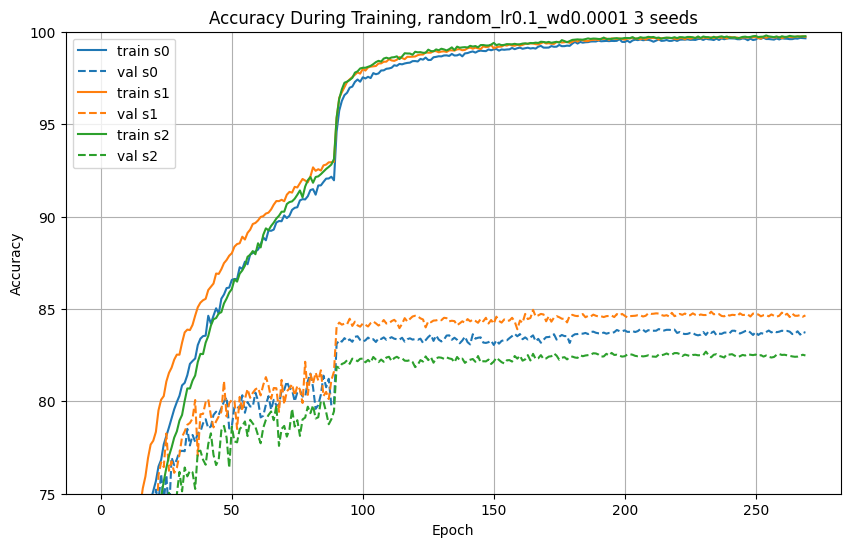

In [326]:
# Ungrouped: Selected Seeds
plot_parsed_metrics(
    get_plt_cfg(ylim=(75,100)),
    run_group_metrics,
    lr=0.1,
    wd=1e-4,
    init="random",
    seeds=[0,1,2],
    splits=['train', 'val'],
    group_seeds=False,
)

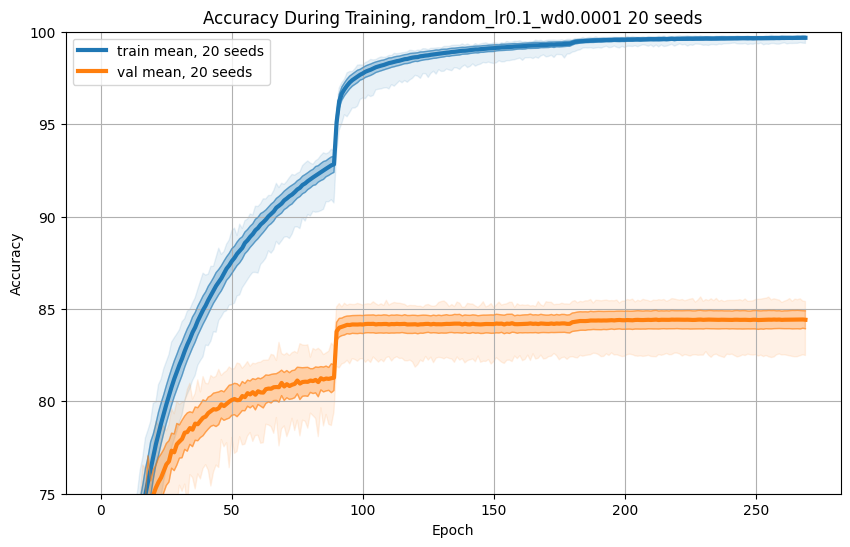

In [327]:
# Grouped: Some Seeds
plot_parsed_metrics(
    get_plt_cfg(ylim=(75,100)),
    run_group_metrics,
    lr=0.1,
    wd=1e-4,
    init="random",
    seeds=range(20),
    splits=['train', 'val'],
    group_seeds=True,
)

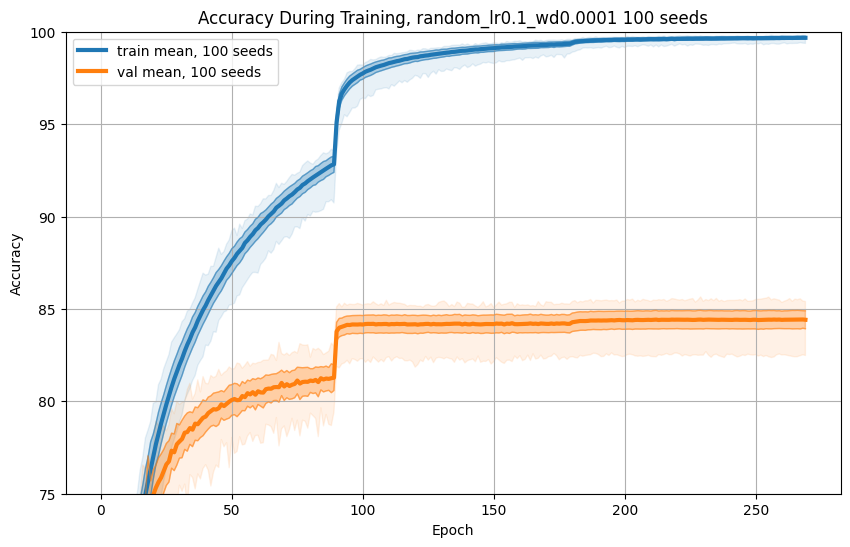

In [328]:
# Grouped, All Seeds
plot_parsed_metrics(
    get_plt_cfg(ylim=(75,100)),
    run_group_metrics,
    lr=0.1,
    wd=1e-4,
    init="random",
    seeds=None,
    splits=['train', 'val'],
    group_seeds=True,
)

### Histogram Plots

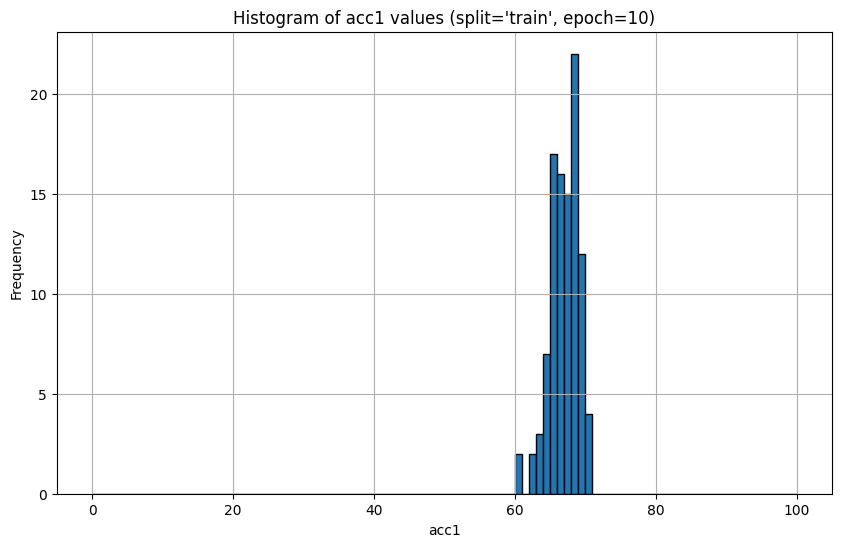

In [223]:
plot_histogram(
    get_plt_cfg(
        legend=True, labels=["random_lr0.1_wd0.0001"], hist_range=(0, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    epoch=10,
    split="train",
)

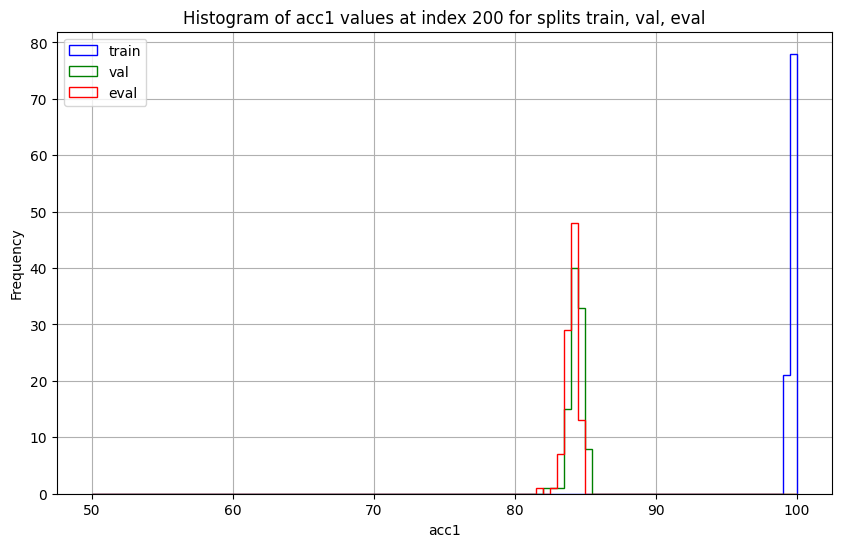

In [229]:
plot_histograms(
    get_plt_cfg(
        legend=True, labels=["train", "val", "eval"], hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    epoch=200,
    splits=["train", "val", "eval"],
)

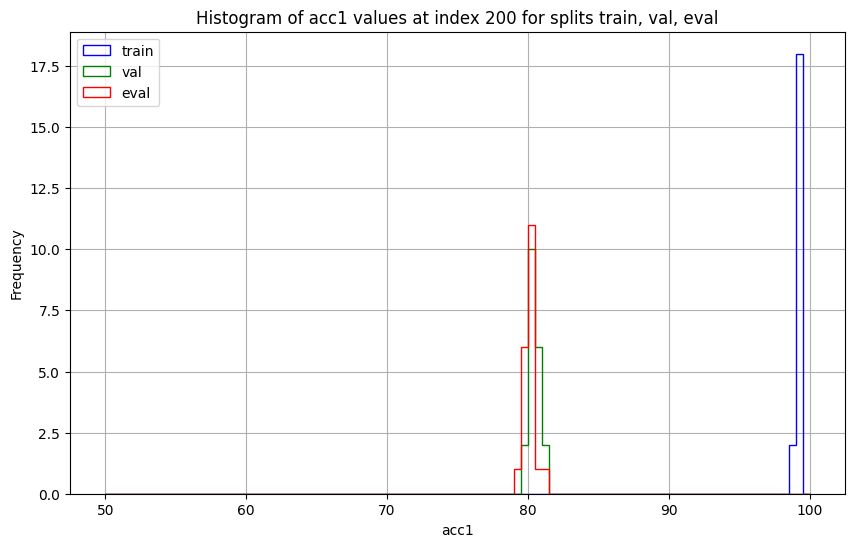

In [228]:
plot_histograms(
    get_plt_cfg(
        legend=True, labels=["train", "val", "eval"], hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    splits=["train", "val", "eval"],
)

### KS Stats Calculations

In [352]:
ex_results = calculate_ks_for_run_sets(
    run_group_metrics['random_lr0.1_wd0.0001'],
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    split="val",
)
print(ex_results['seeds_group_1'], ex_results['seeds_group_2'])

ks_stat: 1.0000, p_value: 8.1460e-23 | max_val: 81.10, cdf1_val: 0.0000, cdf2_val: 1.0000
99 20


In [353]:
ex_results = calculate_ks_for_run_sets(
    run_group_metrics['random_lr0.1_wd0.0001'],
    run_group_metrics['random_lr0.2_wd0.0001'],
    epoch=200,
    split="val",
)
print(ex_results['seeds_group_1'], ex_results['seeds_group_2'])

ks_stat: 0.2692, p_value: 1.4117e-01 | max_val: 84.96, cdf1_val: 0.9192, cdf2_val: 0.6500
99 20


### Comparative Plots

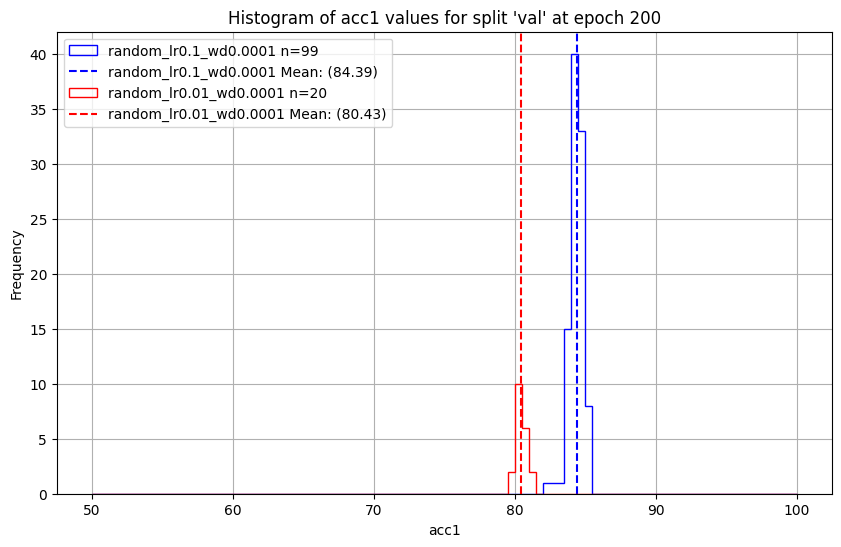

In [366]:
plot_histogram_compare(
    get_plt_cfg(
        legend=True, labels=["random_lr0.1_wd0.0001", "random_lr0.01_wd0.0001"],
        hist_range=(50, 100),
    ),
    run_group_metrics['random_lr0.1_wd0.0001'],
    run_group_metrics['random_lr0.01_wd0.0001'],
    epoch=200,
    split="val",
)

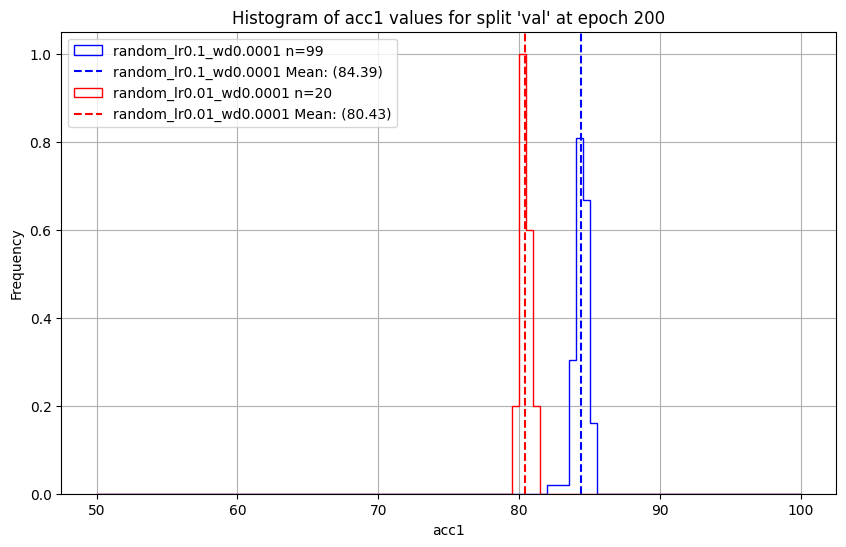

ks_stat: 1.0000, p_value: 8.1460e-23 | max_val: 81.10, cdf1_val: 0.0000, cdf2_val: 1.0000
99 20


In [374]:
present_stats(run_group_metrics, 'random_lr0.1_wd0.0001', 'random_lr0.01_wd0.0001', 200, "val")

### Old

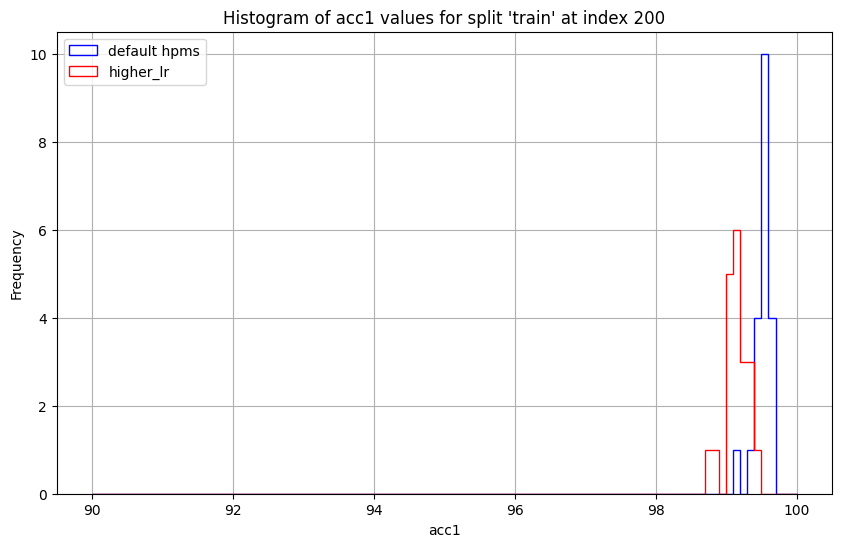

In [98]:
plot_split_histogram_two_run_sets(
    default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="train", hist_range=(90,100), nbins=100, names=['default hpms', 'higher_lr']
)

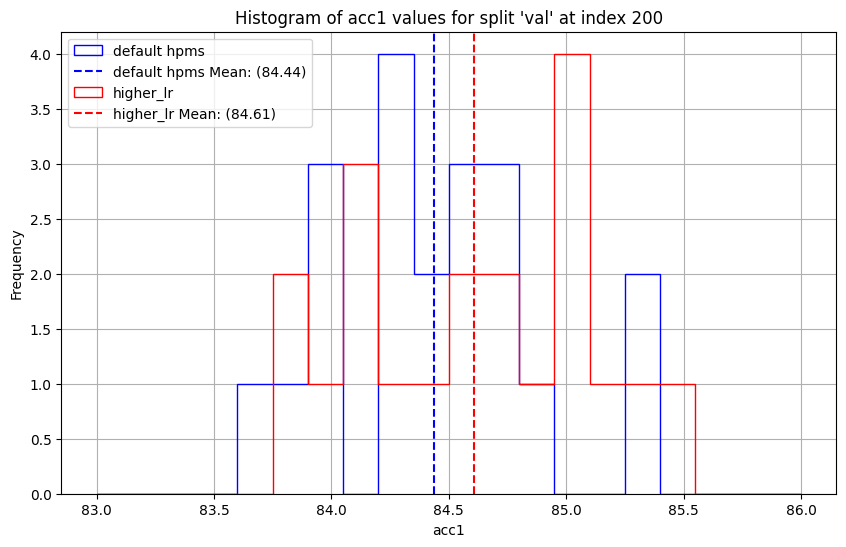

In [104]:
plot_split_histogram_two_run_sets(default_hpm_random_runs, higher_lr_random_runs, index=200, split_name="val", hist_range=(83,86), nbins=20, names=['default hpms', 'higher_lr'])

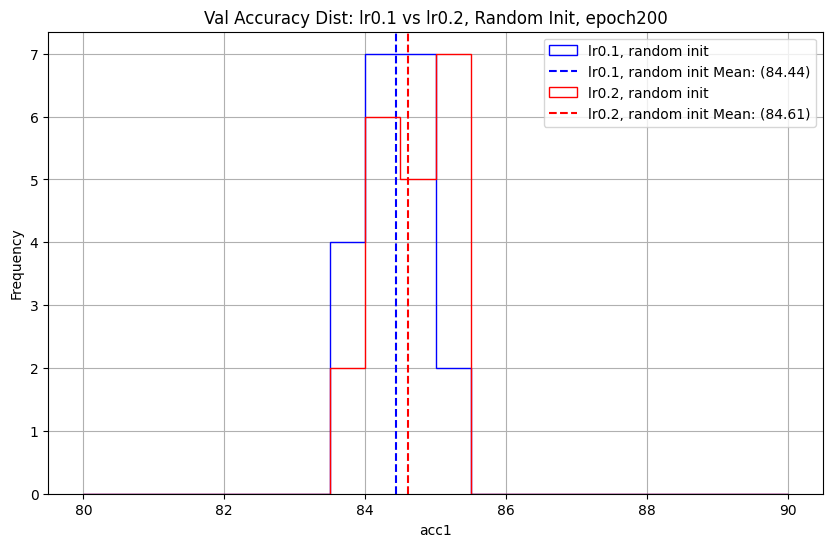

ks_stat: 0.3000, p_value: 3.3559e-01 | max_val: 84.81, cdf1_val: 0.9000, cdf2_val: 0.6000


In [65]:
present_stats(
    default_hpm_random_runs, higher_lr_random_runs,
    "lr0.1, random init", "lr0.2, random init",
    "Val Accuracy Dist: lr0.1 vs lr0.2, Random Init, epoch200",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

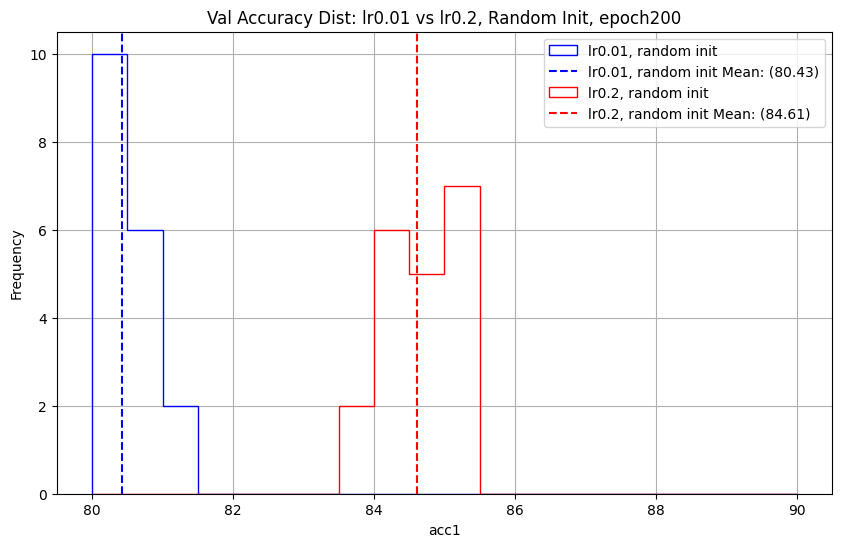

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.10, cdf1_val: 1.0000, cdf2_val: 0.0000


In [66]:
present_stats(
    lower_lr_random_runs, higher_lr_random_runs,
    "lr0.01, random init", "lr0.2, random init",
    "Val Accuracy Dist: lr0.01 vs lr0.2, Random Init, epoch200",
    index=200, split="val", hist_range=(80,90), nbins=20,
)

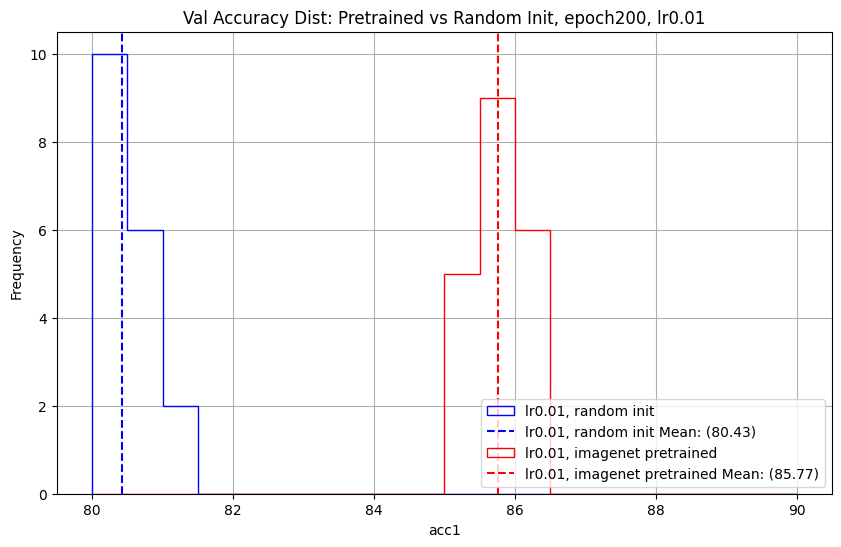

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.10, cdf1_val: 1.0000, cdf2_val: 0.0000


In [63]:
present_stats(
    lower_lr_random_runs, lower_lr_pretrained_runs,
    "lr0.01, random init", "lr0.01, imagenet pretrained",
    "Val Accuracy Dist: Pretrained vs Random Init, epoch200, lr0.01",
    index=200, split="val", hist_range=(80,90), nbins=20,
)